configuration:
models_ver - insert YOLO version's numbers that the UAP will be trained on.

epsilon, lambda_1, lambda_2 - attack's parameters. more information can be found in the [paper](https://arxiv.org/abs/2205.13618)

BDD_IMG_DIR - a path to the BDD validation set images (or any other wanted dataset)

BDD_LAB_DIR - a path to the BDD validation set labels (or any other wanted dataset)

In [1]:
models_vers = [5] # for example: models_vers = [5] or models_vers = [3, 4, 5]
epsilon = 70
lambda_1 = 1
lambda_2 = 10
seed = 42
patch_size=(640,640)
img_size=(640,640)
batch_size = 8
num_workers = 4
max_labels_per_img = 65
BDD_IMG_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val'
BDD_LAB_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/labels/val'

Load BDD dataset:

In [2]:
import torch
import os
import random
import numpy

from datasets.augmentations1 import train_transform
from datasets.split_data_set_combined import SplitDatasetCombined_BDD

/Users/coenschoof/miniconda/envs/phantomsponges/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# batch = [(1, 'a'), (2, 'b'), (3, 'c')]

# unzipped = zip(*batch)

# numbers, letters = unzipped

# print(numbers)  # Output: (1, 2, 3)
# print(letters)  # Output: ('a', 'b', 'c')

#dus ipv [(tensor, array, string), (tensor, array, string), (tensor, array, string)] hebben we
# train_loader[0] bevat 8 images
# train_loader[1] bevat alle labels per voor 8 images
# train_loader[2] bevat paths naar 8 images
def collate_fn(batch):
    return tuple(zip(*batch))

def set_random_seed(seed_value, use_cuda=True):
    numpy.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    random.seed(seed_value)  # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python hash buildin
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [4]:
split_dataset = SplitDatasetCombined_BDD(
            img_dir= BDD_IMG_DIR,
            lab_dir= BDD_LAB_DIR,
            max_lab=max_labels_per_img,
            img_size=img_size,
            transform=train_transform,
            collate_fn=collate_fn)

In [5]:
#train_loader en val_loader 

#train loader bevat een tuple van 3, elk element van de tuple bevat 8 samples (8 samples maakt 1 batch)
#De tuple bestaat uit het volgende:
    #[0] = de image met size (3,640,640)
    #[1] = de bounding boxes met size (x, 5) (5 bestaat uit class, x, y, x, y)
        #lijkt nergens gebruikt te worden
    #[2] = de naam van de image (e.g. 'c98258a4-54a47ff2.jpg')  

    #HEB IK AL DEZE INFORMATIE OOK NODIG WANNEER IK WIL TESTEN OP PASCAL/MTSD? converten is een pain
        #WORDT [2] ERGENS GEBRUIKT? IK WEET DAT [1] NERGENS GEBRUIKT WORDT
train_loader, val_loader, test_loader = split_dataset(val_split=0.1,
                                                      shuffle_dataset=True,
                                                      random_seed=seed,
                                                      batch_size=batch_size,
                                                      ordered=False,
                                                      collate_fn=collate_fn)

create UAP:

In [237]:
import numpy
from attack.uap_phantom_sponge import UAPPhantomSponge

torch.cuda.empty_cache()

patch_name = r"yolov"
for ver in models_vers:
  patch_name += f"_{ver}"
patch_name += f"_epsilon={epsilon}_lambda1={lambda_1}_lambda2={lambda_2}"

uap_phantom_sponge_attack = UAPPhantomSponge(patch_folder=patch_name, 
                                             train_loader=train_loader, 
                                             val_loader=val_loader, 
                                             epsilon = epsilon, 
                                             lambda_1=lambda_1, 
                                             lambda_2=lambda_2, 
                                             #epochs=7,#stond hier voorheen nog niet
                                             patch_size=patch_size, 
                                             models_vers=models_vers)
adv_img = uap_phantom_sponge_attack.run_attack()

Fusing layers... 
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


CUDA Available:  False
local_yolos/yolov5/weights/yolov5s.pt
Epoch:  0
saving png of current patch at epoch: 0, batch: 0/169...
combined_loss, max_obj, bb_area, iou_loss for this batch =               0.353|0.249|0.01|0.0
combined_loss, max_obj, bb_area, iou_loss for this batch =               0.336|0.248|0.009|0.002


KeyboardInterrupt: 

# CODE FOR EVALUATION

In [6]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from local_yolos.yolov5.models.experimental import attempt_load
from local_yolos.yolov5.utils.general import non_max_suppression
from torchvision import transforms
from local_yolos.yolov5.utils.metrics import box_iou
from local_yolos.yolov5.utils.plots import Annotator
import time
from tqdm import tqdm

In [7]:
# Load the YOLOv5 model
model = attempt_load(weights='yolov5s.pt').eval()

Fusing layers... 


yolov5s.pt


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [181]:
def perturb_img(img_name, change_aspect_ratio = True, output_type = "torch", patch_name = 'final_patch.png'):
    image_path = "/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val/" + img_name
    image = Image.open(image_path)
    image = image.resize((640, 640))
    transform = transforms.Compose([transforms.ToTensor()])
    clean_img = transform(image)

    # Load the image using PIL
    patch_path =  "/Users/coenschoof/miniconda/envs/phantomsponges/PhantomSponges/final_patch.png"
    patch = Image.open(patch_path)
    patch = transform(patch)

    perturbed_img = torch.clamp(clean_img + patch, 0, 1)

    # Assuming you have a torch tensor named torch_image
    # You can resize the tensor to (H, W, C) shape using transpose and multiply by 255 (if it's not already in the correct range)
    #pil_image = transforms.ToPILImage()(result.squeeze().cpu() * 255)
    tensor_min = torch.min(perturbed_img)
    tensor_max = torch.max(perturbed_img)
    normalized_tensor = (perturbed_img - tensor_min) / (tensor_max - tensor_min)

    # Convert the normalized tensor to a PIL image
    pil_image = transforms.ToPILImage()(normalized_tensor.squeeze().cpu())
    if change_aspect_ratio:
        random_scale_w = random.uniform(0.7, 0.9) #1.5, 3
        #random_scale_h = random.uniform(1, 2.5)
        width = int(640 * random_scale_w)
        width = (width // 32) * 32 #ensures that the new width is a multiple of 32, otherwise the model does not work
        height = 640 #height = int(640 * random_scale_h)
        height = (height // 32) * 32
        pil_image = pil_image.resize((width, height))

    if output_type == "torch":
        perturbed_image = transform(pil_image)
    elif output_type == "numpy":
        perturbed_image = np.array(pil_image)
    elif output == "pil":
        pass
    else:
        print("Unsupported output type provided!")

    return(perturbed_image)

In [8]:
image_names = []
for image_np, _, image_name in tqdm(test_loader):
    image_names.append(image_name[0])

100%|██████████| 500/500 [00:07<00:00, 62.88it/s]


In [113]:
def compute_recall(box_iou_output):
    true_pos = 0
    for clean_detection in box_iou_output:
        if clean_detection[clean_detection > 0.45].nelement() != 0:
            true_pos += 1

    return true_pos / box_iou_output.size()[0]

In [114]:
def add_bbs(image, xyxys):
    numpy_clean_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    annotator = Annotator(np.ascontiguousarray(numpy_clean_img))
    
    for xyxy in xyxys:
        annotator.box_label(xyxy)
    annotator_results = annotator.result()
    annotator_results = (annotator_results * 255).astype(np.uint8)
    pil_image = Image.fromarray(annotator_results)

    return pil_image

In [115]:
def scale_bbs(orig_dims, target_dims, orig_xyxy):
    # Original image dimensions (640x1200)
    original_height, original_width = orig_dims[2:]

    # Target image dimensions (640x640)
    target_height, target_width = target_dims[2:]

    # Calculate scaling factors for x and y dimensions
    x_scale = target_width / original_width
    y_scale = target_height / original_height

    # Scale the coordinates of the bounding boxes
    scaled_bounding_boxes = orig_xyxy.clone().detach()  # Create a copy to preserve the original data
    scaled_bounding_boxes[:, 0] *= x_scale  # Scale x (left)
    scaled_bounding_boxes[:, 1] *= y_scale  # Scale y (top)
    scaled_bounding_boxes[:, 2] *= x_scale  # Scale x2 (right)
    scaled_bounding_boxes[:, 3] *= y_scale  # Scale y2 (bottom)

    return scaled_bounding_boxes

In [184]:
def evaluate_results(loader = test_loader, Tconf = 0.25, Tiou = 0.45, max_det_pert=300, max_det_clean=300, change_aspect_ratio = False, patch_name = 'final_patch.png'):
    all_total_times = []
    all_nms_times = []
    all_num_bbs_before_nms = []
    all_recalls = []

    for image_np, _, image_name in tqdm(loader):
        perturbed_img = perturb_img(image_name[0],change_aspect_ratio = change_aspect_ratio, patch_name = patch_name).unsqueeze(0)
        clean_img = image_np[0].unsqueeze(0)

        total_times_single_img = []
        nms_times_single_img = []

        start_time_1 = time.time() * 1000
        output_perturbed = model(perturbed_img)[0]
        start_time_2 = time.time() * 1000
        keep_perturbed = non_max_suppression(output_perturbed, Tconf, Tiou, classes=None,max_det=max_det_pert)
        end_time = time.time() * 1000 
        total_time = end_time - start_time_1
        nms_time = end_time - start_time_2

        total_times_single_img.append(total_time)
        nms_times_single_img.append(nms_time)

        output_clean = model(clean_img)[0]
        keep_clean = non_max_suppression(output_clean, Tconf, Tiou, classes=None,max_det=max_det_clean)

        num_bbs_before_nms_mask = output_perturbed[..., 4] > Tconf 
        num_bbs_before_nms = num_bbs_before_nms_mask.sum().item()   #F(C')

        clean_xyxy = keep_clean[0][:,0:4]

        # with_bbs = add_bbs(clean_img, clean_xyxy)
        # display(with_bbs)
        perturbed_xyxy = keep_perturbed[0][:,0:4]

        # with_bbs = add_bbs(perturbed_img, perturbed_xyxy)
        # display(with_bbs)

        scaled_perturbed_xyxy = scale_bbs(orig_dims=perturbed_img.shape, target_dims=clean_img.shape, orig_xyxy = perturbed_xyxy)

        # resized_perturbed_img = F.interpolate(perturbed_img, size=(640,640), mode='bilinear', align_corners=False)
        # with_bbs = add_bbs(resized_perturbed_img, scaled_perturbed_xyxy)
        # display(with_bbs)

        box_iou_output = box_iou(clean_xyxy, scaled_perturbed_xyxy)
        
        #check if its the case that there aren't any clean detections
        #in that case, skip computing the recall
        #"the number of original objects detected in the perturbed image"
        #if there aren't any original objects, no recall can be calculated, thus we skip
        if clean_xyxy.nelement() != 0:
            recall = compute_recall(box_iou_output)
            all_recalls.append(recall)


        all_total_times.append(total_time)
        all_nms_times.append(nms_time)
        all_num_bbs_before_nms.append(num_bbs_before_nms)
        
    avg_total_time = sum(all_total_times) / len(all_total_times)
    avg_nms_time = sum(all_nms_times) / len(all_nms_times)
    avg_num_bbs_before_nms = sum(all_num_bbs_before_nms) / len(all_num_bbs_before_nms)
    avg_recall = sum(all_recalls) / len(all_recalls)

    return round(avg_total_time, 1), round(avg_nms_time, 1), round(avg_num_bbs_before_nms), round(avg_recall, 3)

In [185]:
results = evaluate_results()

  4%|▍         | 21/500 [00:23<08:50,  1.11s/it]


KeyboardInterrupt: 

# New loss term experiments

In [149]:
import torchvision
from local_yolos.yolov5.utils.general import non_max_suppression, xyxy2xywh

In [146]:
def bboxes_area_on_steroids(output_clean, output_patch, conf_thres=0.25):
    def xywh2xyxy(x):
        y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2
        y[:, 1] = x[:, 1] - x[:, 3] / 2
        y[:, 2] = x[:, 0] + x[:, 2] / 2
        y[:, 3] = x[:, 1] + x[:, 3] / 2
        return y

    def box_area(box):
        # box = xyxy(4,n)
        return (box[2] - box[0]) * (box[3] - box[1])

    def box_iou(box1, box2):
        # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            box1 (Tensor[N, 4])
            box2 (Tensor[M, 4])
        Returns:
            iou (Tensor[N, M]): the NxM matrix containing the pairwise
                IoU values for every element in boxes1 and boxes2
        """

        # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
        (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
        inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

        # IoU = inter / (area1 + area2 - inter)
        return inter / (box_area(box1.T)[:, None] + box_area(box2.T) - inter)

    t_loss = 0.0
    not_nan_count = 0

    with torch.no_grad():
        # For each img in the batch
        for (xi, x) in enumerate(output_patch):  # image index, image inference
            # Filter out predictions with confidence below the threshold
            xc_patch = x[..., 4] > conf_thres
            x1 = x[xc_patch]

            if x1.numel() == 0:
                print("YOLO could not find any BBs on this image")
                continue

            # Extract relevant information from predictions
            x2 = x1[:, 5:] * x1[:, 4:5]
            box_x1 = xywh2xyxy(x1[:, :4])
            print(box_x1.shape)

            # Calculate IoU only for valid predictions
            iou = box_iou(box_x1, box_x1)#.to(torch.float16)
            mask = torch.triu(torch.ones(iou.shape[0], iou.shape[1]), diagonal=1)
            upper_triangular_tensor = iou[mask.bool()]

            if upper_triangular_tensor.numel() > 0:
                img_loss = upper_triangular_tensor.sum() / len(upper_triangular_tensor)
                t_loss += img_loss
                not_nan_count += 1

    if not_nan_count == 0:
        t_loss_f = torch.tensor(torch.nan)
    else:
        t_loss_f = t_loss / not_nan_count

    return t_loss_f, iou


In [11]:
#create a tiny batch containing 3 images; 2 random images from the test set, and a fully white image

zeros_tensor = torch.zeros(1, 3, 640, 640)
zero_output = model(zeros_tensor)[0]

random_index = random.randrange(len(image_names))
other_image = perturb_img(image_names[random_index], change_aspect_ratio = False, output_type = "torch").unsqueeze(0)
random_index = random.randrange(len(image_names))
other_image_2 = perturb_img(image_names[random_index], change_aspect_ratio = False, output_type = "torch").unsqueeze(0)
pil_image = transforms.ToPILImage()(other_image.squeeze())
#display(pil_image)

tiny_batch = torch.cat((other_image, other_image_2, zeros_tensor))
tiny_batch_output = model(tiny_batch)

In [148]:
box, iou = bboxes_area_on_steroids(tiny_batch_output[0], tiny_batch_output[0])

torch.Size([4081, 4])
torch.Size([1198, 4])
YOLO could not find any BBs on this image


In [71]:
# Dit hieronder werkt veel te traag!!

# import itertools

# def box_iou(boxes):
#     # Calculate the IoU between every pair of bounding boxes in 'boxes', excluding self-overlaps.
#     # Input 'boxes' is expected to be in the format xyxy(n, 4),
#     # where each row represents a bounding box in the format [x1, y1, x2, y2].

#     num_boxes = boxes.shape[0]
#     iou_list = []

#     for i, j in itertools.combinations(range(num_boxes), 2):
#         box1 = boxes[i]
#         box2 = boxes[j]

#         # Compute the intersection area
#         lt = torch.max(box1[:2], box2[:2])
#         rb = torch.min(box1[2:], box2[2:])
#         wh = (rb - lt).clamp(min=0)
#         inter = wh[0] * wh[1]

#         # Compute the areas of the bounding boxes
#         area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
#         area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

#         # Calculate IoU
#         iou = inter / (area1 + area2 - inter)
#         iou_list.append(iou.item())

#     return iou_list


# Experiments for removal of phantom bounding boxes post-NMS

In [55]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import DBSCAN

  0%|          | 0/500 [00:00<?, ?it/s]

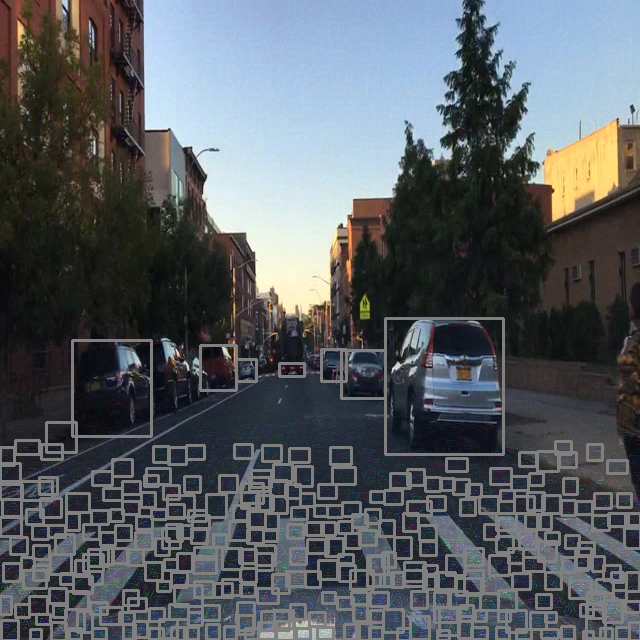

/Users/coenschoof/miniconda/envs/phantomsponges/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


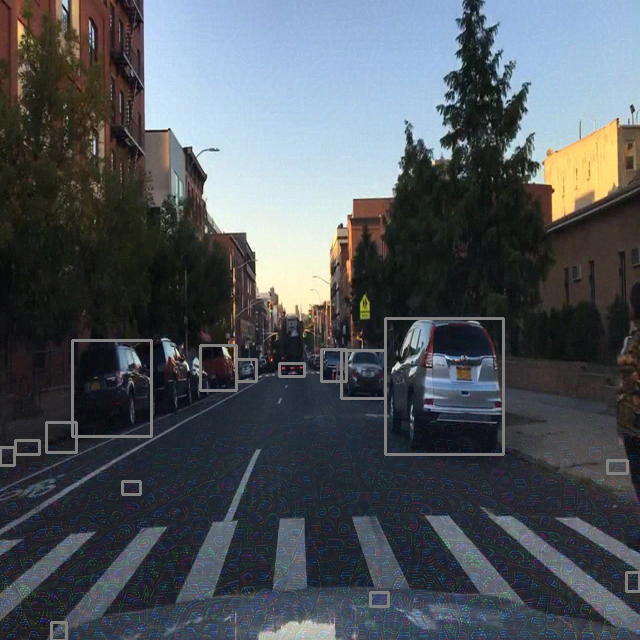

  0%|          | 0/500 [00:00<?, ?it/s]


In [191]:
for image_np, _, image_name in tqdm(test_loader):
    perturbed_img = perturb_img(image_name[0],change_aspect_ratio = False).unsqueeze(0)

    output_perturbed = model(perturbed_img)[0]
    keep_perturbed = non_max_suppression(output_perturbed, 0.25, 0.45, classes=None,max_det=300)
    output_data = keep_perturbed[0].numpy()
    data = output_data.copy()
    with_bbs = add_bbs(perturbed_img, output_data)
    display(with_bbs)


    scaler = MinMaxScaler()
    data[:, :4] = scaler.fit_transform(data[:, :4]) 
    data[:, 4] = (data[:, 4] - data[:, 4].min()) / (data[:, 4].max() - data[:, 4].min())
    one_hot_encoder = OneHotEncoder(sparse=False)
    class_labels_encoded = one_hot_encoder.fit_transform(data[:, 5].reshape(-1, 1))
    data = np.concatenate((data[:, :5], class_labels_encoded), 1)
    
    # Define the DBSCAN clustering model
    eps = 0.3  # Maximum distance between two samples to be considered in the same neighborhood
    min_samples = 15  # Minimum number of samples in a neighborhood to form a core point
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    xyxy_after_phantom_removal = output_data[labels == -1]

    with_bbs = add_bbs(perturbed_img, xyxy_after_phantom_removal)
    display(with_bbs)
    break